# Solving the 1D Diffusion Equation with a Neural Network

In [2]:
import torch
from torch import nn
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

In [3]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn import *

In [4]:
# Double-precision by default
torch.set_default_dtype(torch.float64)

### 1D Diffusion Equation

In [5]:
# Functions below specify the initial boundary value problem alongside its analytic solution

def unpack_sample(xt):
    return xt[:,0].reshape(-1,1), xt[:,-1].reshape(-1,1)

def u0(x, t):
    return torch.sin(torch.pi * x)

def dirichlet_bc(u, x, t):
    return torch.zeros_like(x)

def diffusion_equation(u, x, t):
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    
    return u_xx - u_t

def u_analytical(x, t):
    return np.sin(np.pi * x) *np.exp(-(torch.pi)**2 * t)

def spatio_temporal_sample(T, N_st, N_s, N_t, kind="lhs"):
    if kind == "lhs":
        sampler1d = lambda N: torch.from_numpy(LatinHypercube(1).random(n = N))
        # Excludes boundaries naturally
        sampler2d = lambda N: torch.from_numpy(LatinHypercube(2).random(n = N))
    elif kind == "uniform":
        sampler1d = lambda N: torch.from_numpy(np.linspace(0, 1, N).reshape(-1,1))
        # Drop first and last
        sampler2d = lambda N: torch.from_numpy(np.dstack(np.meshgrid(sampler1d(N+2)[1:-1], 
                                                                     sampler1d(N+1)[1:])).reshape(-1, 2))
        N_st = int(np.sqrt(N_st))
        N_s = N_s // 2
    
    #Interior points
    samples_xt = sampler2d(N_st)
    #samples_x = samples_xt[:,0].reshape(-1,1)
    #samples_t = T * samples_xt[:,1].reshape(-1,1)
    
    # Spatial points at t=0 (initial conditions)
    samples_x_ic = sampler1d(N_t)
    samples_t_ic = torch.zeros((N_t,1))
    
    # Temporal points at x=0,1 (boundary conditions)
    samples_t_bc = torch.repeat_interleave(T * sampler1d(N_s), 2, dim=0)
    samples_x_bc = torch.empty((2 * N_s,1))
    samples_x_bc[0::2,0] = 0.
    samples_x_bc[1::2,0] = 1.
    
    return samples_xt, \
           torch.cat((samples_x_ic, samples_t_ic),1), \
           torch.cat((samples_x_bc, samples_t_bc), 1)

## Proof of Concept

### Generate Test/Train Split

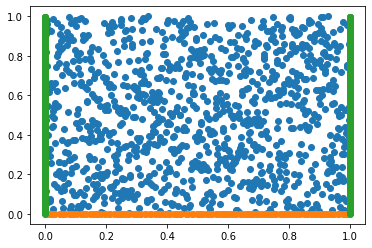

In [6]:
#IBVP parameters
T = 1
N_interior =  2**10
N_bc = 2**9
N_ic = 2**7

# Generate training set
X_train = spatio_temporal_sample(T, N_interior, N_bc, N_ic, kind="lhs")
xt_int, xt_ic, xt_bc = X_train

# Generate test data
X_test = spatio_temporal_sample(T, N_interior, N_bc, N_ic)

plt.scatter(*unpack_sample(xt_int))
plt.scatter(*unpack_sample(xt_ic))
plt.scatter(*unpack_sample(xt_bc))
#plt.scatter(x_boundary2, t_boundary, c="green")
plt.show()

### Training of the Network

In [8]:
diffusion_nn = PiNN(diffusion_equation, dirichlet_bc, u0, verbose=True)
diffusion_nn.fit(X_train, None)

---------------------------Hyperparameters----------------------------
# of collocation points per batch:                                1024
# of boundary points per batch:                                   1024
# of initial condition points per batch:                           128
# of minbatches:                                                     1
Points per Iteration:                                        134217728
Iterations:                                                        100
Total number of collocation points                         13421772800
----------------------------------------------------------------------
  Epoch   |  Total Loss   |  Loss (PDE)   |   Loss (BC)   |   Loss (IC)   
    0     |   1.566877e-01|   1.076704e-02|   6.397238e-02|   8.194827e-02
    10    |   4.591646e-04|   3.936553e-04|   5.455634e-05|   1.095293e-05
    20    |   6.482708e-05|   4.694807e-05|   9.029757e-06|   8.849245e-06
    30    |   2.108447e-05|   1.838870e-05|   1.990102e-06|  

In [88]:
def train_network_to_ibvp(X_train, X_test, pde, ic, bc, hyperparameters=None, verbose=True):
    
    # Unpack the training data into interior/ic/bc points and set up the minibatch indices
    (x_int, t_int), (x_init, t_init), (x_boundary, x_boundary2, t_boundary) = X_train
            
    if X_test is None:
        X_test = X_train
        
    # Default Hyperparameters for model and learning
    if hyperparameters is None:
        hidden_layers = [20,20,20]
        batchsize_interior= x_int.shape[0]
        batchsize_boundary= x_boundary.shape[0]
        batchsize_ic = x_init.shape[0]
        number_of_minibatches=1
        epochs = 100
    else:
        for key,val in hyperparameters.items():
            exec(key + '=val')
        
    # Unpack the test data into interior/ic/bc points
    (x_int_test, t_int_test), (x_init_test, t_init_test), (x_boundary_test, x_boundary2_test, t_boundary_test) = X_test
    x_int_test.requires_grad_(True)
    t_int_test.requires_grad_(True)
        
    # Minibatch index set to iterate over
    idx_int = np.array_split(np.arange(x_int.shape[0]), number_of_minibatches)
    idx_init = np.array_split(np.arange(x_init.shape[0]), number_of_minibatches)
    idx_boundary = np.array_split(np.arange(x_boundary.shape[0]), number_of_minibatches)

    net = PiNN(hidden_layers)
    
    optimizer = torch.optim.LBFGS(net.parameters())
    loss_fn = torch.nn.MSELoss()
    
    if verbose:
        mse_train = []
        mse_test = []
        report_after_e_epochs = min(epochs, 10)
    
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f'{"Hyperparameters":-^70}')
    print(f'{"Network:":<40}')
    print(net)
    print(f'{"# of model parameters:":<40}{params:>30}\n')
    print(f'{"# of collocation points per batch:":<40}{batchsize_interior:>30}')
    print(f'{"# of boundary points per batch:":<40}{batchsize_boundary:>30}')
    print(f'{"# of initial condition points per batch:":<40}{batchsize_ic:>30}')
    print(f'{"# of minbatches:":<40}{number_of_minibatches:>30}')
    print(f'{"Points per Iteration:":<40}{batchsize_interior * batchsize_boundary * batchsize_ic * number_of_minibatches:>30}')
    print(f'{"Iterations:":<40}{epochs:>30}')
    print(f'{"Total number of collocation points":<40}{epochs * batchsize_interior * batchsize_boundary * batchsize_ic * number_of_minibatches:>30}')
    print(f'{"":-^70}')
    print(f'{"Epoch":^10}|{"Total Loss":^15}|{"Loss (PDE)":^15}|{"Loss (BC)":^15}|{"Loss (IC)":^15}')
        
    for e in range(epochs+1):
        for minibatch in range(number_of_minibatches):

            x = x_int[idx_int[minibatch],:]
            t = t_int[idx_int[minibatch],:]
            
            x_ic = x_init[idx_init[minibatch],:]
            t_ic = t_init[idx_init[minibatch],:]
            
            x_bc_0 = x_boundary[idx_boundary[minibatch],:]
            x_bc_L = x_boundary2[idx_boundary[minibatch],:]
            t_bc = t_boundary[idx_boundary[minibatch],:]
            
            x.requires_grad_(True)
            t.requires_grad_(True)
            
            last_total_loss_in_step = 0
            last_interior_loss_in_step = 0
            last_bc_loss_in_step = 0
            last_ic_loss_in_step = 0
            
            def compute_loss(x, t, x_ic, t_ic, x_bc_0, x_bc_L, t_bc, for_optimization=True):
                nonlocal last_total_loss_in_step, last_interior_loss_in_step, last_bc_loss_in_step, last_ic_loss_in_step
            
                if for_optimization:
                    optimizer.zero_grad()
            
                # Interior
                u = net(x, t)
                mse_interior = loss_fn(pde(u,x,t), torch.zeros_like(u))
            
                # Boundary Condition
                u_bc_0 = net(x_bc_0, t_bc)
                u_bc_L = net(x_bc_L, t_bc)
                mse_boundary = loss_fn(u_bc_0, bc(x_bc_0, t_bc)) + loss_fn(u_bc_L, bc(x_bc_L, t_bc))
        
                # Initial conditions
                u_ic = net(x_ic, t_ic)
                mse_ic = loss_fn(u_ic, ic(x_ic))
        
                #Total Loss
                loss =  mse_interior + mse_boundary + mse_ic
                
                if for_optimization:
                    loss.backward()
            
                last_total_loss_in_step = loss.item()
                last_interior_loss_in_step = mse_interior.item()
                last_bc_loss_in_step = mse_boundary.item()
                last_ic_loss_in_step = mse_ic.item()
                
                # pytorch requires that only the total loss is returned from the closure
                return loss
            
            optimizer.step(lambda: compute_loss(x, t, 
                                                x_ic, t_ic, 
                                                x_bc_0, x_bc_L, t_bc, 
                                                for_optimization=True))
            if verbose:
                mse_train.append([last_total_loss_in_step, last_interior_loss_in_step, last_bc_loss_in_step, last_ic_loss_in_step])
            
                compute_loss(x_int_test, t_int_test, 
                             x_init_test, t_init_test, 
                             x_boundary_test, x_boundary2_test, t_boundary_test,
                             for_optimization=False)
                
                mse_test.append([last_total_loss_in_step, last_interior_loss_in_step, last_bc_loss_in_step, last_ic_loss_in_step])
            
        if verbose and e % report_after_e_epochs == 0:
            print(f'{e:^10}|{last_total_loss_in_step:>15.6e}|{last_interior_loss_in_step:>15.6e}|{last_bc_loss_in_step:>15.6e}|{last_ic_loss_in_step:>15.6e}')
    if verbose:
        return net, mse_train, mse_test
    return net

### Comparison between PiNN and Analytical Solution

In [89]:
net, mse_train, mse_test = train_network_to_ibvp(X_train, X_test, diffusion_equation, u0, dirichlet_bc)

---------------------------Hyperparameters----------------------------
Network:                                
PiNN(
  (ff_relu_graph): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
  )
  (output): Linear(in_features=20, out_features=1, bias=True)
)
# of model parameters:                                             921

# of collocation points per batch:                                1024
# of boundary points per batch:                                    512
# of initial condition points per batch:                           128
# of minbatches:                                                     1
Points per Iteration:                                         67108864
Iterations:                                                        100
Total number of collocation points                        

In [11]:
def dstack_product(x, y):
     return np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
    
N_t = 1000
N_x = 900
t = np.linspace(0, T, N_t)
x = np.linspace(0, 1, N_x)
xx, tt = np.meshgrid(x,t)
u_ana = u_analytical(xx,tt)
xt = dstack_product(x,t)

X_test = (torch.from_numpy(xt[:,0].reshape(-1,1)),torch.from_numpy(xt[:,1]).reshape(-1,1))
#Dummy to satisfy the predictor API of project 1. y_test is never used in PiNN !
y_test = torch.empty(xt.shape[0])
u_net = diffusion_nn.predict(X_test).reshape(N_t, N_x)

fig, ax = plt.subplots(nrows=3, sharex=True)

for a in ax:
    a.xaxis.tick_top()
    a.xaxis.set_label_position('top') 
for tk in ax[0].get_xticklabels():
    tk.set_visible(True)
for tk in ax[-1].get_xticklabels():
    tk.set_visible(True)
    
ax[0].pcolormesh(tt,xx,u_ana)
ax[1].pcolormesh(tt,xx,u_net)
im = ax[2].pcolormesh(tt, xx, u_net-u_ana,
                      cmap="coolwarm",
                      norm=colors.CenteredNorm())

divider = make_axes_locatable(ax[2])
cax = divider.new_vertical(size="25%", pad=0.1, pack_start=True)
fig.add_axes(cax)
cax.set_xlabel(r"$u_\text{analytical} - u_{net}$")
fig.colorbar(im, cax=cax, orientation="horizontal")

ax[0].set_xlabel(r"$t$")
plt.show()

(tensor([[0.0000],
        [0.0011],
        [0.0022],
        ...,
        [0.9978],
        [0.9989],
        [1.0000]]), tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]]))


TypeError: unbind() received an invalid combination of arguments - got (tuple, dim=int), but expected one of:
 * (Tensor input, int dim)
      didn't match because some of the arguments have invalid types: (!tuple!, dim=int)
 * (Tensor input, name dim)
      didn't match because some of the arguments have invalid types: (!tuple!, !dim=int!)


## Parameter Study

In [16]:
a = torch.arange(4)
print(torch.vstack((a,a)).T)

tensor([[0, 0],
        [1, 1],
        [2, 2],
        [3, 3]])


In [10]:
xt = torch.vstack((torch.arange(5), 2 * torch.arange(5))).T.float()
xt.requires_grad_(True)
print(xt)
x = xt[:,0].reshape(-1,1)
t = xt[:,1].reshape(-1,1)
u = 2 * xt[:,0] * xt[:,1]
print(u)
u_x = derivative(u, x)
print(u_x)

tensor([[0., 0.],
        [1., 2.],
        [2., 4.],
        [3., 6.],
        [4., 8.]], dtype=torch.float32, requires_grad=True)
tensor([ 0.,  4., 16., 36., 64.], dtype=torch.float32, grad_fn=<MulBackward0>)


IndexError: too many indices for tensor of dimension 1

In [21]:
def grid_search(model, hyperparameters, metric, ):
    metric_grid = np.empty(hyperparam)

AttributeError: 'tuple' object has no attribute 'shape'

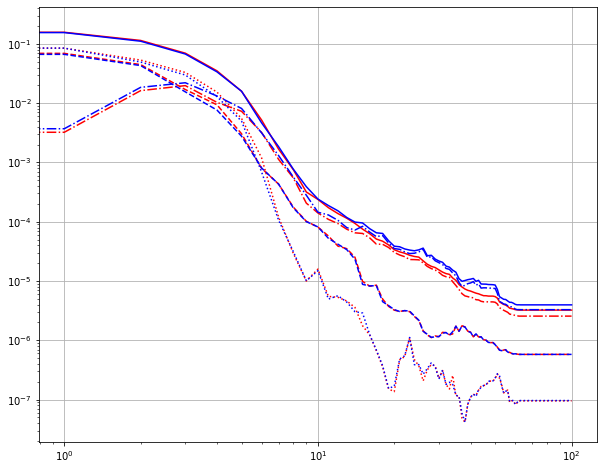

In [81]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xscale("log")
ax.set_yscale("log")
epoch = np.arange(len(mse_test))
mse_train = np.array(mse_train)
mse_test = np.array(mse_test)
ax.plot(epoch, mse_train[:,0], color="red", ls="solid")
ax.plot(epoch, mse_train[:,1], color="red", ls="dashdot")
ax.plot(epoch, mse_train[:,2], color="red", ls="dashed")
ax.plot(epoch, mse_train[:,3], color="red", ls="dotted")

ax.plot(epoch, mse_test[:,0], color="blue", ls="solid")
ax.plot(epoch, mse_test[:,1], color="blue", ls="dashdot")
ax.plot(epoch, mse_test[:,2], color="blue", ls="dashed")
ax.plot(epoch, mse_test[:,3], color="blue", ls="dotted")
ax.grid(True)
plt.show()